# Pose Estimation Flow

In [1]:
data_dir = "data/calib"
videos_dir = "data/calib/original"
videos_detected_dir = "data/calib/detected"
csvs_dir = "data/calib/csvs"
matrices_dir = "data/matrices"
experiment_timestamp = "20210526-132415" 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Camera Matrices Calculation

#### Aruco Chess Board Creation

In [ ]:
%run calculate_cameras_matrices -h

Notice: this would open a window with the first frame of the video. Please select the asked points with a rightclick.

In [ ]:
%run calculate_cameras_matrices -d {videos_dir} -t {experiment_timestamp}  -m {matrices_dir}

### Examine data

In [3]:
import pandas as pd
import os
files = [file for file in os.listdir(csvs_dir) if experiment_timestamp in file and 'filtered' not in file]
files

['calib_long_back_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500.csv',
 'calib_long_left_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500.csv',
 'calib_long_right_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500.csv',
 'calib_long_top_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500.csv']

In [4]:
from smooth_2d_pose_estimation import write_filtered_data 

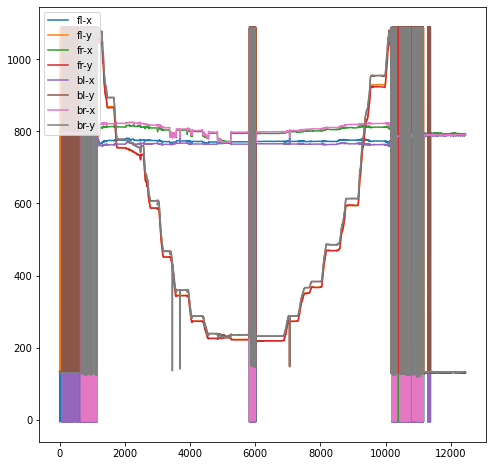

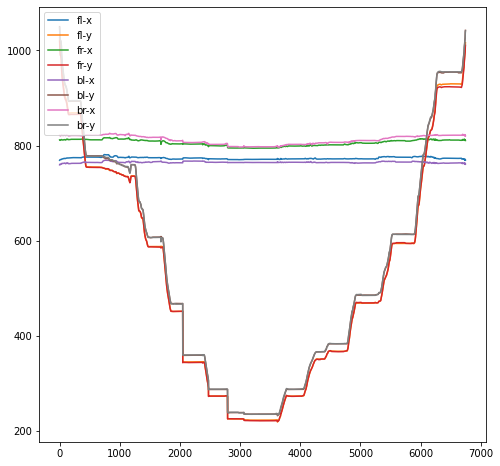

calib_long_back_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500
output: data/calib/csvs/calib_long_back_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv


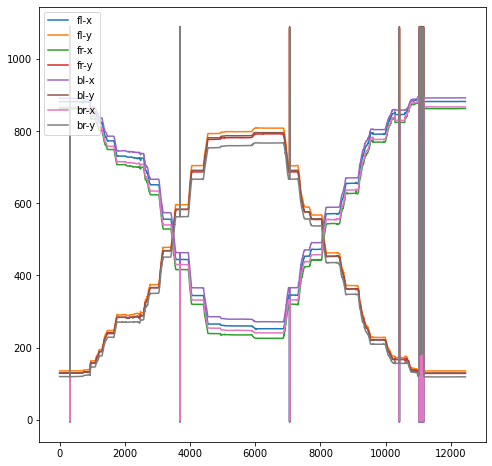

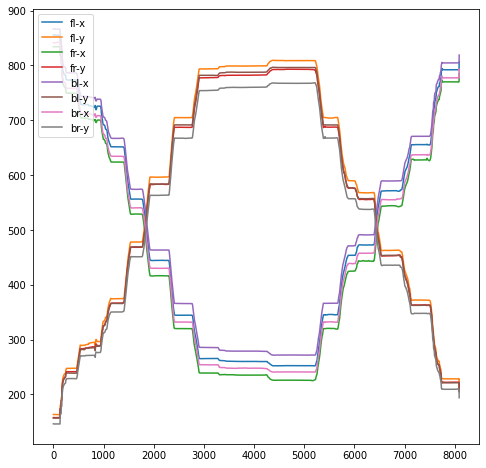

calib_long_left_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500
output: data/calib/csvs/calib_long_left_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv


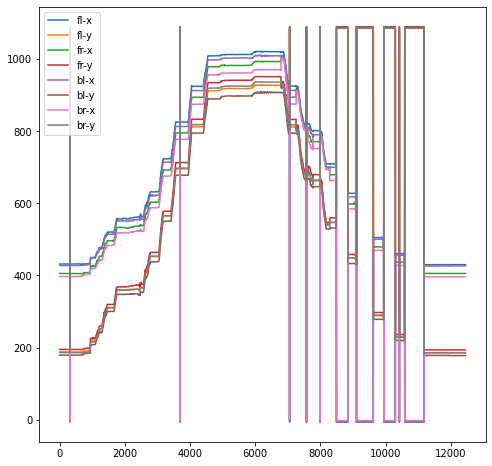

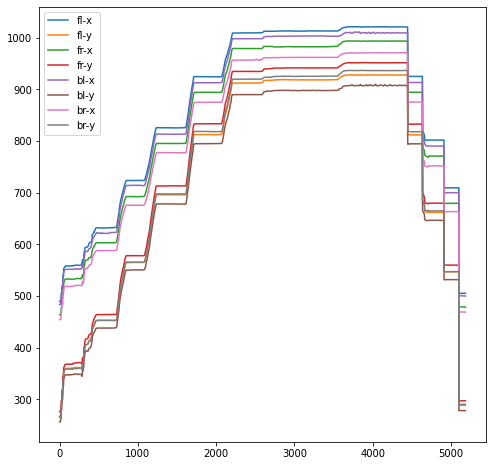

calib_long_right_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500
output: data/calib/csvs/calib_long_right_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv


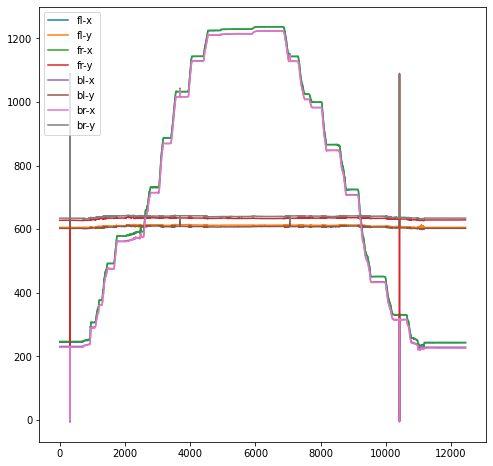

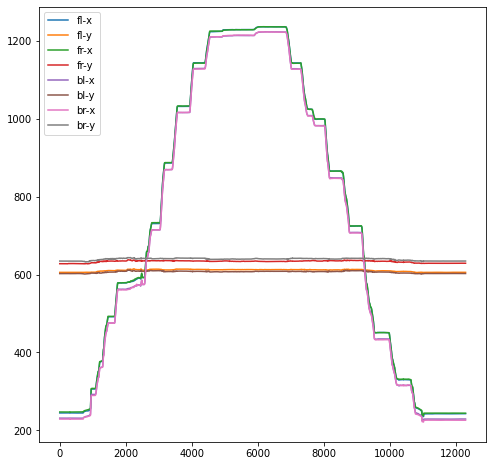

calib_long_top_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500
output: data/calib/csvs/calib_long_top_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv


In [5]:
for file in files:
    write_filtered_data(csvs_dir, file)

### Transform pixels to 3d coordinates 

In [7]:
%run pixels_locations_to_arena_coordinates -h

usage: pixels_locations_to_arena_coordinates.py [-h] [-o OUTPUT] [--csv CSV] [-m MATRICES_DIR] [-t TIMESTAMP]
                                                [-l LIKELIHOOD] [-f FILTER] [-v VIDEOS_DIR] [-s SHOW_VIDEO]

optional arguments:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        directory of the output
  --csv CSV
  -m MATRICES_DIR, --matrices_dir MATRICES_DIR
                        directory of the input matrices
  -t TIMESTAMP, --timestamp TIMESTAMP
                        the timestamp of the experiment
  -l LIKELIHOOD, --likelihood LIKELIHOOD
                        the minimum likelihood of points to use
  -f FILTER, --filter FILTER
                        file name filter
  -v VIDEOS_DIR, --videos_dir VIDEOS_DIR
                        the videos dir if you want to visualize result
  -s SHOW_VIDEO, --show_video SHOW_VIDEO


In [10]:
%run pixels_locations_to_arena_coordinates -o {videos_detected_dir} --csv {csvs_dir} -t {experiment_timestamp} -f filtered -l 0.95 -m {matrices_dir}

read experiments csvs: ['calib_long_back_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv', 'calib_long_left_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv', 'calib_long_right_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv', 'calib_long_top_20210526-132415DLC_resnet50_calib_all_V2Jul12shuffle1_49500_filtered.csv']
analyzing camera: Camera.BACK
Progress:  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
analyzing camera: Camera.LEFT
Progress:  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
analyzing camera: Camera.RIGHT
Progress:  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
analyzing camera: Camera.TOP
Progress:  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


### Show results videos

In [33]:
video_name = "calib_width_back_20210526-134439.mp4"
detected_video_name = "134439_back_detected.mp4"

In [34]:
from IPython.display import HTML
from os import path
video_path=path.join(videos_dir, video_name)
detected_video_path=path.join(videos_detected_dir, detected_video_name)
HTML(f"""
<video width=450 controls>
      <source src="{video_path}" type="video/mp4">
</video>
<video width=450 controls>
      <source src="{detected_video_path}" type="video/mp4">
</video>
""")

### Analyze data

In [11]:
import pandas as pd
csv_path = r'data/calib/detected\points\20210526-132415_points_073120211912.csv'
df = pd.read_csv(csv_path)
df

,topFLx,leftFLx,rightFLx,backFLx,topFLy,leftFLy,rightFLy,backFLy,topFLz,leftFLz,...,rightdirectionx,backdirectionx,topdirectiony,leftdirectiony,rightdirectiony,backdirectiony,topdirectionz,leftdirectionz,rightdirectionz,backdirectionz
0,7.965387,NaN,NaN,NaN,31.925882,NaN,NaN,NaN,6.257831,NaN,...,NaN,NaN,31.258265,NaN,NaN,NaN,7.084237,NaN,NaN,NaN
1,7.965387,NaN,NaN,NaN,31.925882,NaN,NaN,NaN,6.257831,NaN,...,NaN,NaN,31.258265,NaN,NaN,NaN,7.084237,NaN,NaN,NaN
2,7.965387,NaN,NaN,NaN,31.925882,NaN,NaN,NaN,6.257831,NaN,...,NaN,NaN,31.258265,NaN,NaN,NaN,7.084237,NaN,NaN,NaN
3,7.965387,NaN,NaN,NaN,31.925882,NaN,NaN,NaN,6.257831,NaN,...,NaN,NaN,31.258265,NaN,NaN,NaN,7.084237,NaN,NaN,NaN
4,9.266273,NaN,NaN,NaN,31.902091,NaN,NaN,NaN,8.552852,NaN,...,NaN,NaN,31.281073,NaN,NaN,NaN,9.415751,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12441,8.968125,NaN,NaN,NaN,31.852283,NaN,NaN,NaN,8.355111,NaN,...,NaN,NaN,31.187005,NaN,NaN,NaN,9.198083,NaN,NaN,NaN
12442,8.968125,NaN,NaN,NaN,31.852283,NaN,NaN,NaN,8.355111,NaN,...,NaN,NaN,31.187005,NaN,NaN,NaN,9.198083,NaN,NaN,NaN
12443,8.968125,NaN,NaN,NaN,31.852283,NaN,NaN,NaN,8.355111,NaN,...,NaN,NaN,31.187005,NaN,NaN,NaN,9.198083,NaN,NaN,NaN
12444,8.968125,NaN,NaN,NaN,31.852283,NaN,NaN,NaN,8.355111,NaN,...,NaN,NaN,31.187005,NaN,NaN,NaN,9.198083,NaN,NaN,NaN


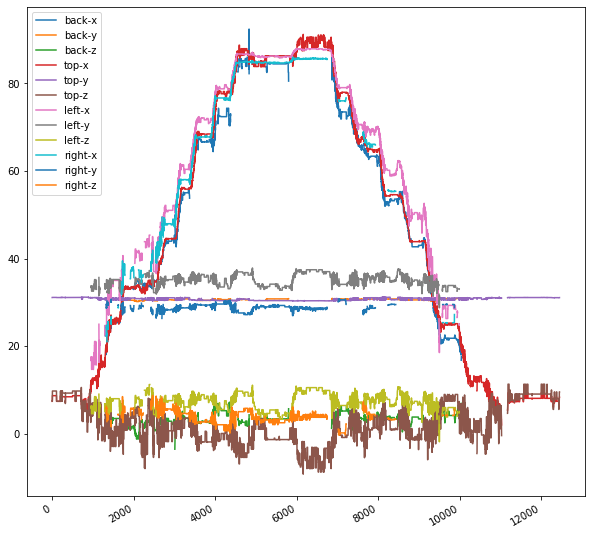

In [12]:
x = df['backcenterx']
y = df['backcentery']
z = df['backcenterz']
topx = df['topcenterx']
topy = df['topcentery']
topz = df['topcenterz']
leftx = df['leftcenterx']
lefty = df['leftcentery']
leftz = df['leftcenterz']
rightx = df['rightcenterx']
righty = df['rightcentery']
rightz = df['rightcenterz']
time = list(range(len(x)))
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))
plt.plot(time,x, label='back-x')
plt.plot(time,y, label='back-y')
plt.plot(time,z, label='back-z')

plt.plot(time,topx, label='top-x')
plt.plot(time,topy, label='top-y')
plt.plot(time,topz, label='top-z')

plt.plot(time,leftx, label='left-x')
plt.plot(time,lefty, label='left-y')
plt.plot(time,leftz, label='left-z')

plt.plot(time,rightx, label='right-x')
plt.plot(time,righty, label='right-y')
plt.plot(time,rightz, label='right-z')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()

In [13]:
from scipy.signal import savgol_filter
fieldnames = ["backcenterx", "backcentery","topcenterz", "topcenterx", "topcentery","topcenterz",
             "leftcenterx", "leftcentery","leftcenterz", "rightcenterx", "rightcentery","rightcenterz"]
df.dropna(inplace=True)
df = df.apply(lambda x: savgol_filter(x,61,2) if x.name in fieldnames else x)

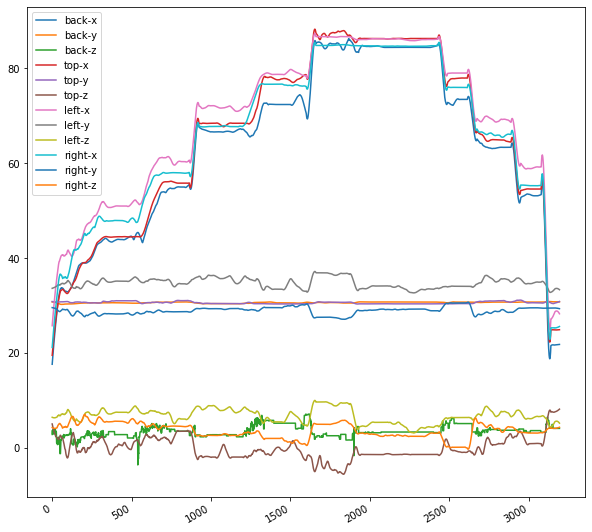

In [14]:
x = df['backcenterx']
y = df['backcentery']
z = df['backcenterz']
topx = df['topcenterx']
topy = df['topcentery']
topz = df['topcenterz']
leftx = df['leftcenterx']
lefty = df['leftcentery']
leftz = df['leftcenterz']
rightx = df['rightcenterx']
righty = df['rightcentery']
rightz = df['rightcenterz']
time = list(range(len(x)))
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))
plt.plot(time,x, label='back-x')
plt.plot(time,y, label='back-y')
plt.plot(time,z, label='back-z')

plt.plot(time,topx, label='top-x')
plt.plot(time,topy, label='top-y')
plt.plot(time,topz, label='top-z')

plt.plot(time,leftx, label='left-x')
plt.plot(time,lefty, label='left-y')
plt.plot(time,leftz, label='left-z')

plt.plot(time,rightx, label='right-x')
plt.plot(time,righty, label='right-y')
plt.plot(time,rightz, label='right-z')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()

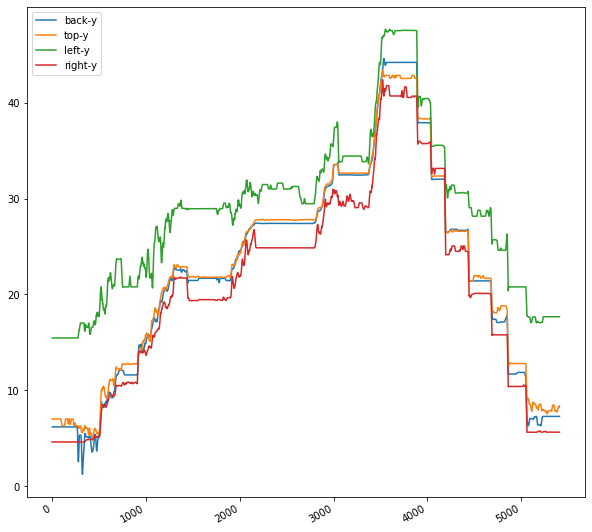

In [8]:
x = df['backcentery']
topx = df['topcentery']
leftx = df['leftcentery']
rightx = df['rightcentery']
time = list(range(len(x)))
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))
plt.plot(time,x, label='back-y')
plt.plot(time,topx, label='top-y')
plt.plot(time,leftx, label='left-y')
plt.plot(time,rightx, label='right-y')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()

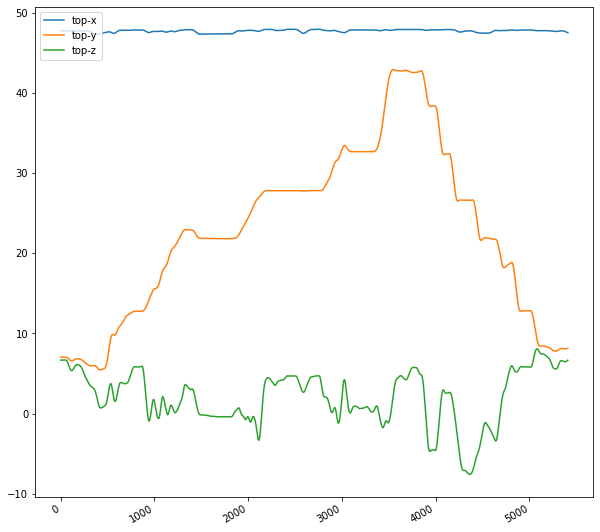

In [35]:
import matplotlib.pyplot as plt
# plot
plt.figure(figsize=(10,10))

plt.plot(time,topx, label='top-x')
plt.plot(time,topy, label='top-y')
plt.plot(time,topz, label='top-z')
plt.gcf().autofmt_xdate()

plt.legend(loc='upper left')
plt.show()